# Advanced Data Mining

## Models learning

### Classification with Hidden Markov Model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
from hmmlearn import hmm
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectPercentile
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

from scripts.colors import bold
from scripts.utils import checkpoint

Load data from previous step

In [2]:
df = checkpoint("03-cleaned")

rows, cols = df.shape
print("Dataframe contains", bold(f"{rows} rows"), "and", bold(f"{cols} columns"))

Dataframe contains 19933 rows and 21 columns


In [3]:
label_encoder = LabelEncoder()
X = CountVectorizer().fit_transform(df['body']).toarray()
y = label_encoder.fit_transform(df['subreddit'])

X = SelectPercentile(percentile=10).fit_transform(X, y)
print(f'Data after SelectPercentile: {X.shape}')

X = LatentDirichletAllocation(n_components=20).fit_transform(X)
print(f'Data after LDA: {X.shape}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Data after SelectPercentile: (19933, 2124)
Data after LDA: (19933, 20)


In [4]:
def compute_transition_array(sequence):
    states = np.unique(sequence)
    n_states = len(states)
    M = np.zeros((n_states, n_states))
    for (i, j) in zip(sequence, sequence[1:]):
        M[i][j] += 1
    return M / M.sum(1).reshape(-1, 1)


def return_init_params(train_data, n_states, model=None):
    if model is None:
        gm = GaussianMixture(n_components=n_states)
    else:
        gm = GaussianMixture(
            n_components=n_states,
            means_init=model.means_,
            weights_init=model.startprob_,
            precisions_init=np.linalg.inv(model.covars_)
        )
        transmat = model.transmat_

    gm.fit(train_data)
    states = gm.predict(train_data)
    transmat = compute_transition_array(states)
    edge = gm.means_
    covs = gm.covariances_.diagonal(0, 1, 2)
    pda = gm.weights_ / gm.weights_.sum()

    return transmat, covs, pda, edge, gm

In [5]:
n_states = 10
not_converged = True

while not_converged:
    model = None
    transmat_init, covars_init, startprob_init, means_init, gm = return_init_params(
        X_train, n_states, model)

    model = hmm.GaussianHMM(
        n_components=n_states,
        algorithm='viterbi',
        covariance_type='diag',
    )
    model.init_params = ''
    model.transmat_ = transmat_init
    model.covars_ = covars_init
    model.startprob_ = startprob_init
    model.means_ = means_init

    sequences = [sample.reshape(-1, 1) for sample in X_train]

    # Combine all samples into a single array
    all_sequences = np.vstack(sequences)
    lengths = [len(seq) for seq in sequences]

    model.fit(all_sequences, lengths)

    try:
        states = [model.decode(
            seq.reshape(-1, 1), algorithm='viterbi')[1] for seq in X_train]
        not_converged = False
    except:
        print('Model did not converge. Trying again...')

Model is not converging.  Current: 32411339.394733936 is not greater than 32415208.28822771. Delta is -3868.8934937752783


In [6]:
states = [model.decode(seq.reshape(-1, 1), algorithm='viterbi')[1] for seq in X_train]
states = np.vstack(states)
assert states.shape[0] == y_train.shape[0]

states.shape

(13953, 20)

In [7]:
# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # For multi-class classification
    num_class=5,  # Number of classes in the dataset
    max_depth=5,  # Depth of the decision trees
    learning_rate=0.25,  # Learning rate for boosting steps
    n_estimators=100,  # Number of boosting rounds (trees)
)

xgb_model = xgb_model.fit(states, y_train)

In [8]:
test_states = [model.decode(seq.reshape(-1, 1), algorithm='viterbi')[1] for seq in X_test]
test_states = np.vstack(test_states)

In [9]:
y_pred = xgb_model.predict(test_states)

In [10]:
labels = label_encoder.classes_

print(f"Accuracy: {round(accuracy_score(y_test, y_pred) * 100, 2)}%")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=labels))
with open(f'results/hmm_xgb.txt', 'w') as f:
    f.write(classification_report(y_test, y_pred, target_names=labels))

Accuracy: 73.03%
Classification Report:
              precision    recall  f1-score   support

      gaming       0.83      0.76      0.79      1213
    politics       0.70      0.78      0.74      1221
 programming       0.79      0.79      0.79      1187
     science       0.72      0.77      0.74      1178
  technology       0.61      0.55      0.58      1181

    accuracy                           0.73      5980
   macro avg       0.73      0.73      0.73      5980
weighted avg       0.73      0.73      0.73      5980



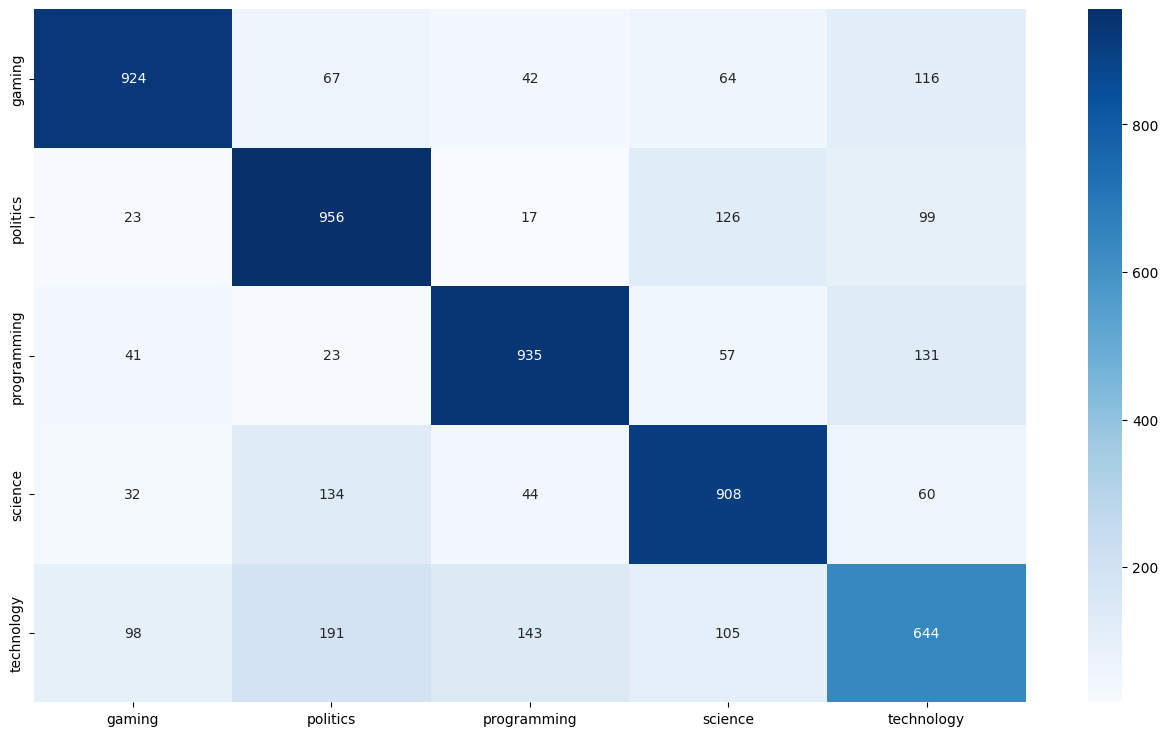

In [11]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(16, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.savefig('images/hmm_xgb_confusion_matrix.png')
plt.show()

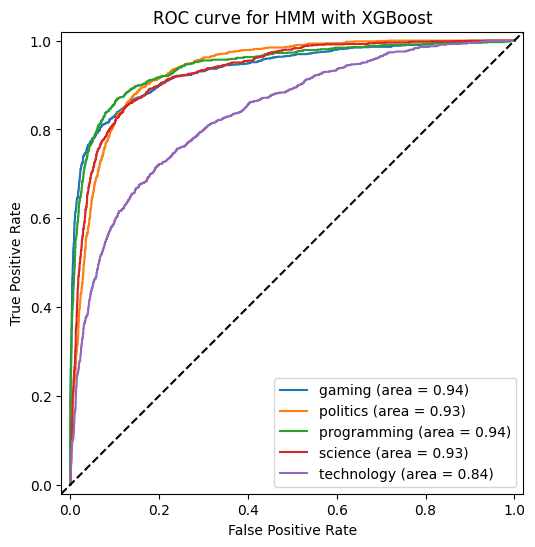

In [12]:
y_score = xgb_model.predict_proba(test_states)

# Plot ROC curve
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
limits = [-0.02, 1.02]
plt.figure(figsize=(6, 6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (area = {roc_auc:.2f})')
plt.plot(limits, limits, 'k--')
plt.xlim(limits)
plt.ylim(limits)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title(f'ROC curve for HMM with XGBoost')
plt.gca().set_aspect('equal')
plt.savefig(f'images/roc_hmm_xgboost.png', bbox_inches='tight')
plt.show()